# Expanding the measurement of culture with a sample of two billion humans

## Replication Data and Code

This notebook provides all the steps to replicate the results of our paper [Expanding the measurement of culture with a sample of two billion humans](https://doi.org/10.1098/rsif.2022.0085) published in the *Journal of the Royal Society Interface 19:20220085* (2022).

## Robustness Analysis
## Robustness to Penetration above Median

# Setup and Pre-requisites

Let's start by importing the required packages

In [1]:
#%pylab --no-import-all
%matplotlib inline

import sys, os, time
import numpy as np
import pandas as pd
pd.set_option('display.width', 160)
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, manhattan_distances, pairwise_distances
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import spatial, stats
from scipy.stats import zscore
import MantelTest.MantelTest as MantelTest
import re
import seaborn as sns

Let's setup our paths

In [2]:
mytype = 'penetration'
cut = 'above'

In [3]:
pathfb = './data/'
pathfbor = './data/OriginalData/'
pathregs = pathfb + 'Regs/'
pathsamples = pathfb + '/DemographicData/'  

pathout = pathregs + 'Representativeness/'
if os.path.exists(pathout) == False:
    os.mkdir(pathout)
pathshare = pathout
if os.path.exists(pathfbor) == False:
    os.mkdir(pathfbor)

pathout = pathregs + 'Representativeness/' + mytype + '/'
if os.path.exists(pathout) == False:
    os.mkdir(pathout)
pathout = pathout + cut + '/'
if os.path.exists(pathout) == False:
    os.mkdir(pathout)
pathshare = pathout 

## Import Data

In [4]:
# Type of distance measure
m = 'Cos'

# Import all data
df = pd.read_stata(pathregs + 'AllDistsFull.dta')

# Import all distances
mypairs = pd.read_stata(pathregs + 'AllDists.dta')
mypairs.drop([x for x in mypairs.columns if x.endswith('uk') or x.endswith('usa')], inplace=True, axis=1)
mypairs.drop([x for x in mypairs.columns if x.find('cognate')!=-1], inplace=True, axis=1)

# Import samples
sample_all = pd.read_excel(pathsamples + 'SampleCountries.xlsx', sheet_name=1, keep_default_na=False, na_values=[''])
sample_wvs = pd.read_excel(pathsamples + 'SampleCountries.xlsx', sheet_name=2, keep_default_na=False, na_values=[''])
sample_repr = pd.read_stata(pathsamples + 'representative_all.dta')

/Users/ozak/anaconda3/envs/GeoPython39env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
sample_repr

,countrycode3,pop_tot,shareWDI_age,shareWDI_gender,countryname,fbpenetration,WVS,shareFB_age,shareFB_gender,countrynameFB,penetrationWDI_age,penetration_tot,diffgender,diffage,pctage,pctgender
0,CHN,1.386395e+09,0.288391,0.514821,China,0.00,1.0,0.657890,0.615631,CN,0.002946,0.004544,0.100810,0.369499,0.052015,0.007033
1,TCD,1.489999e+07,0.553384,0.499404,Chad,0.02,NaN,0.649067,0.834220,TD,0.015872,0.009396,0.334817,0.095683,0.079544,0.016224
2,TKM,5.758075e+06,0.409793,0.490754,Turkmenistan,0.00,NaN,0.327031,0.472757,TM,0.004564,0.011462,0.017997,0.082761,0.093721,0.019765
3,SSD,1.257571e+07,0.515470,0.499250,South Sudan,0.01,NaN,0.538432,0.783775,SS,0.031825,0.017494,0.284525,0.022962,0.108701,0.027796
4,CAF,4.659080e+06,0.529828,0.492986,Central African Republic,0.02,NaN,0.519295,0.709647,CF,0.043283,0.023610,0.216661,0.010534,0.122169,0.041294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,BRN,4.286970e+05,0.348671,0.517849,Brunei Darussalam,0.81,NaN,0.434901,0.563942,BN,1.139706,1.003039,0.046093,0.086230,NaN,NaN
172,BHR,1.492584e+06,0.339478,0.660007,Bahrain,0.70,NaN,0.460658,0.737863,BH,0.920223,1.004969,0.077856,0.121181,NaN,NaN
173,KWT,4.136528e+06,0.271252,0.589644,Kuwait,0.74,NaN,0.433159,0.708900,KW,0.940266,1.039519,0.119256,0.161907,NaN,NaN
174,ARE,9.400145e+06,0.286527,0.759823,United Arab Emirates,0.91,NaN,0.475820,0.742728,AE,1.122771,1.170195,0.017095,0.189293,NaN,NaN


In [6]:
# Generate cutoffs
if cut=='above':
    sample_repr['diff' + mytype +'_median'] = (sample_repr[mytype + '_tot']>sample_repr[mytype + '_tot'].median()).astype(int)
    sample_repr['diff' + mytype +'_median_wvs'] = (sample_repr[mytype + '_tot']>sample_repr.loc[sample_repr.WVS==1][mytype + '_tot'].median()).astype(int)
else:
    sample_repr['diff' + mytype +'_median'] = (sample_repr[mytype + '_tot']<sample_repr[mytype + '_tot'].median()).astype(int)
    sample_repr['diff' + mytype +'_median_wvs'] = (sample_repr[mytype + '_tot']<sample_repr.loc[sample_repr.WVS==1][mytype + '_tot'].median()).astype(int)
mysample_all = sample_all.countrycode2.unique()
mysample_wvs = sample_wvs.countrycode2.unique()
mysample_repr = sample_repr.countrynameFB.unique()
mysample_repr = sample_repr.loc[sample_repr['diff' + mytype +'_median_wvs']==1].countrynameFB.unique()

# Drop countries not in sample
mysample = mysample_repr
mypairs = mypairs.loc[np.logical_and(mypairs.ISO_CODE_1.apply(lambda x: x in mysample), mypairs.ISO_CODE_2.apply(lambda x: x in mysample))].copy()
df = df.loc[np.logical_and(df.ISO_CODE_1.apply(lambda x: x in mysample), df.ISO_CODE_2.apply(lambda x: x in mysample))].copy()

# Correlations Between Facebook Distances and Other Distances
## Graphical Analysis

Let's plot the correlation between all measures and our FB measure

### Pairwise correlations full sample

#### Pearson Correlations

In [7]:
SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

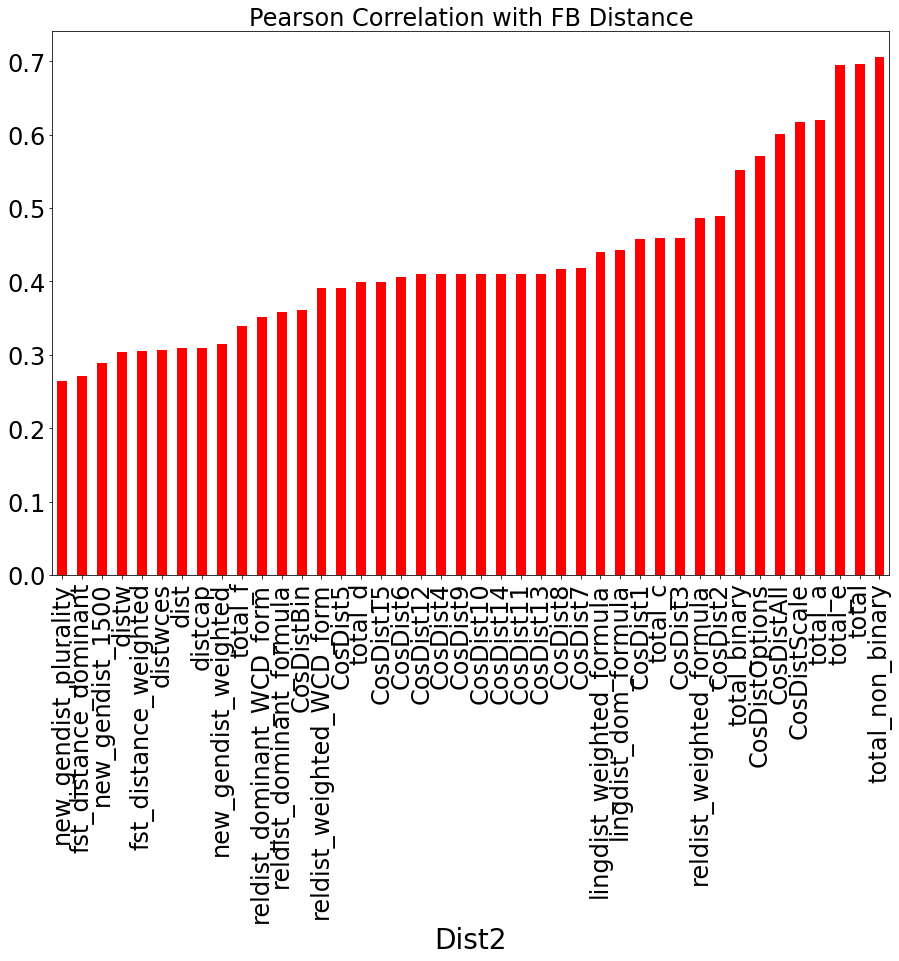

In [8]:
# All correlations
cols = ['Dist1', 'Dist2']
corrs = mypairs.corr().copy()
spear_corrs = mypairs.corr(method='spearman').copy()
corrs = corrs.stack()
spear_corrs = spear_corrs.stack()
corrs = corrs.reset_index()
spear_corrs = spear_corrs.reset_index()
corrs.columns = ['Dist1', 'Dist2', 'Corr']
spear_corrs.columns = ['Dist1', 'Dist2', 'SpCorr']
FBcorr = corrs.loc[corrs.Dist1=='FBDist'].copy()
FBspcorr = spear_corrs.loc[spear_corrs.Dist1=='FBDist'].copy()
FBcorr.reset_index(inplace=True, drop=True)
FBspcorr.reset_index(inplace=True, drop=True)
FBcorr.sort_values('Corr', inplace=True)
FBspcorr.sort_values('SpCorr', inplace=True)
FBcorr.reset_index(inplace=True, drop=True)
FBspcorr.reset_index(inplace=True, drop=True)
FBcorr = FBcorr.loc[FBcorr.Dist2!='FBDist'].copy()
FBspcorr = FBspcorr.loc[FBspcorr.Dist2!='FBDist'].copy()

fig, ax = plt.subplots(figsize=(15,10))
FBcorr.plot.bar(y='Corr', x='Dist2', color='red', ax=ax)
ax.set_title('Pearson Correlation with FB Distance')
ax.legend_.remove()
plt.savefig(pathout+'FBcorr.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Pairwise Common Sample

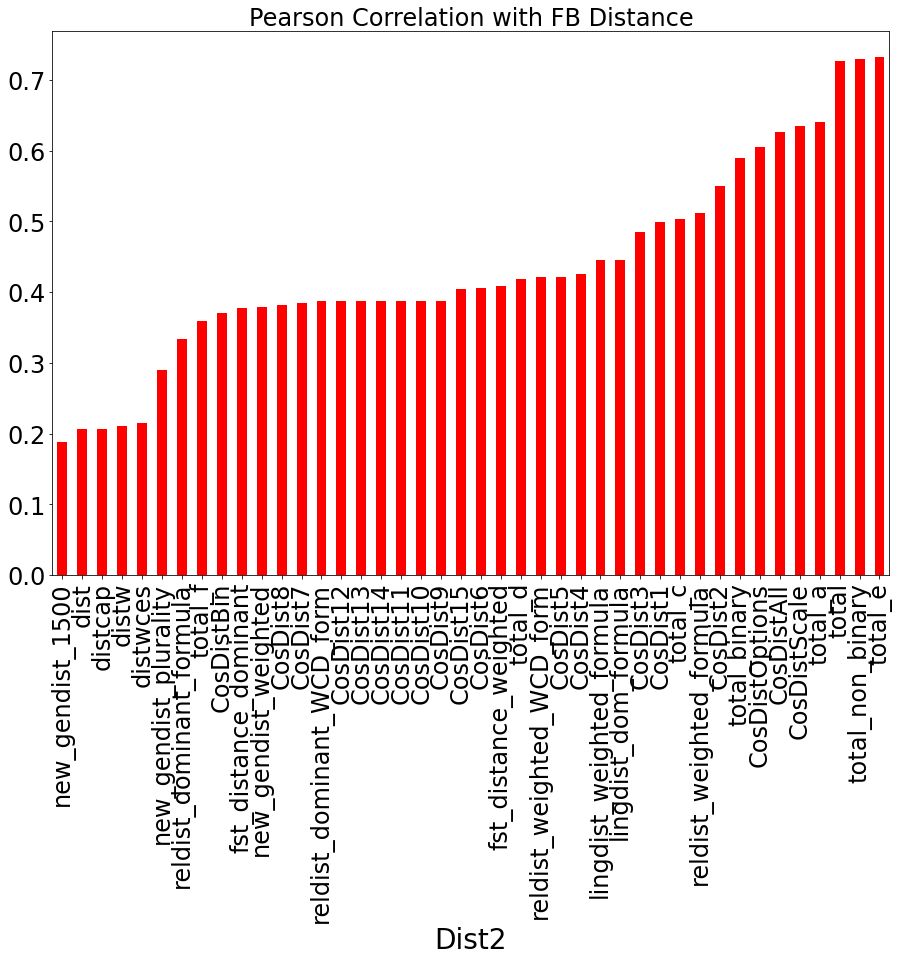

In [9]:
measures = ['FBDist', 'distcap', 'CosDist15', 'reldist_weighted_WCD_form', 'new_gendist_weighted', 'total']
mypairs_com = mypairs.dropna(subset=measures).copy()
mypairs_com.reset_index(inplace=True, drop=True)
corrs_com = mypairs_com.corr().copy()
spear_corrs_com = mypairs_com.corr(method='spearman').copy()
corrs_com = corrs_com.stack()
spear_corrs_com = spear_corrs_com.stack()
corrs_com = corrs_com.reset_index()
spear_corrs_com = spear_corrs_com.reset_index()
corrs_com.columns = ['Dist1', 'Dist2', 'Corr']
spear_corrs_com.columns = ['Dist1', 'Dist2', 'SpCorr']
FBcorr_com = corrs_com.loc[corrs_com.Dist1=='FBDist'].copy()
FBspcorr_com = spear_corrs_com.loc[spear_corrs_com.Dist1=='FBDist'].copy()
FBcorr_com.reset_index(inplace=True, drop=True)
FBspcorr_com.reset_index(inplace=True, drop=True)
FBcorr_com.sort_values('Corr', inplace=True)
FBspcorr_com.sort_values('SpCorr', inplace=True)
FBcorr_com.reset_index(inplace=True, drop=True)
FBspcorr_com.reset_index(inplace=True, drop=True)
FBcorr_com = FBcorr_com.loc[FBcorr_com.Dist2!='FBDist'].copy()
FBspcorr_com = FBspcorr_com.loc[FBspcorr_com.Dist2!='FBDist'].copy()
fig, ax = plt.subplots(figsize=(15,10))
FBcorr_com.plot.bar(y='Corr', x='Dist2', color='red', ax=ax)
ax.set_title('Pearson Correlation with FB Distance')
ax.legend_.remove()
plt.savefig(pathout+'FBcorr_com.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Prepare data for plotting

In [10]:
# We need to construct some stats and prepare the data for plotting

# Remove if Dist1==Dist2
corrs2 = corrs.loc[corrs.Dist1!=corrs.Dist2].copy()
spear_corrs2 = spear_corrs.loc[spear_corrs.Dist1!=spear_corrs.Dist2].copy()

mean_corrs = corrs2.groupby('Dist1').mean()
mean_spcorrs = spear_corrs2.groupby('Dist1').mean()
mean_corrs = mean_corrs.reset_index()
mean_spcorrs = mean_spcorrs.reset_index()
mean_corrs['Dist2'] = 'Average'
mean_spcorrs['Dist2'] = 'Average'
mean_corrs.columns = ['Dist2', 'Corr', 'Average']
mean_spcorrs.columns = ['Dist2', 'SpCorr', 'Average']

corrs_com2 = corrs_com.loc[corrs_com.Dist1!=corrs_com.Dist2].copy()
spear_corrs_com2 = spear_corrs_com.loc[spear_corrs_com.Dist1!=spear_corrs_com.Dist2].copy()

mean_corrs_com = corrs_com2.groupby('Dist1').mean()
mean_spcorrs_com = spear_corrs_com2.groupby('Dist1').mean()
mean_corrs_com = mean_corrs_com.reset_index()
mean_spcorrs_com = mean_spcorrs_com.reset_index()
mean_corrs_com['Dist2'] = 'Average'
mean_spcorrs_com['Dist2'] = 'Average'
mean_corrs_com.columns = ['Dist2', 'Corr', 'Average']
mean_spcorrs_com.columns = ['Dist2', 'SpCorr', 'Average']

# Remove FB from average
NoFBcorrs2 = corrs2.loc[np.logical_and(corrs2.Dist1!='FBDist', corrs2.Dist2!='FBDist')].copy()
NoFBspear_corrs2 = spear_corrs2.loc[np.logical_and(spear_corrs2.Dist1!='FBDist', spear_corrs2.Dist2!='FBDist')].copy()

NoFBmean_corrs = NoFBcorrs2.groupby('Dist1').mean()
NoFBmean_spcorrs = NoFBspear_corrs2.groupby('Dist1').mean()
NoFBmean_corrs = NoFBmean_corrs.reset_index()
NoFBmean_spcorrs = NoFBmean_spcorrs.reset_index()
NoFBmean_corrs['Dist2'] = 'Average (NoFB)'
NoFBmean_spcorrs['Dist2'] = 'Average (NoFB)'
NoFBmean_corrs.columns = ['Dist2', 'Corr', 'AverageNoFB']
NoFBmean_spcorrs.columns = ['Dist2', 'SpCorr', 'AverageNoFB']

NoFBcorrs_com2 = corrs_com2.loc[np.logical_and(corrs_com2.Dist1!='FBDist', corrs_com2.Dist2!='FBDist')].copy()
NoFBspear_corrs_com2 = spear_corrs_com2.loc[np.logical_and(spear_corrs_com2.Dist1!='FBDist', spear_corrs_com2.Dist2!='FBDist')].copy()

NoFBmean_corrs_com = NoFBcorrs_com2.groupby('Dist1').mean()
NoFBmean_spcorrs_com = NoFBspear_corrs_com2.groupby('Dist1').mean()
NoFBmean_corrs_com = NoFBmean_corrs_com.reset_index()
NoFBmean_spcorrs_com = NoFBmean_spcorrs_com.reset_index()
NoFBmean_corrs_com['Dist2'] = 'Average (NoFB)'
NoFBmean_spcorrs_com['Dist2'] = 'Average (NoFB)'
NoFBmean_corrs_com.columns = ['Dist2', 'Corr', 'AverageNoFB']
NoFBmean_spcorrs_com.columns = ['Dist2', 'SpCorr', 'AverageNoFB']

langcols = [i for i in mypairs.columns if re.findall(r"^\w+[Cosdist]+[0-9]{1,2}", i)!=[]]
geocols = [i for i in mypairs.columns if i.startswith('dist')]
def assign_type(x):
    '''Assign to each measure a type: Genetic, WVS, Religios, Linguistic
    '''
    if x in langcols or x.find('ling')!=-1 or x.find('cognate')!=-1 :
        y = 'Linguistic'
    elif x.find('total')!=-1 or x=='CosDistScale' or x=='CosDistBin' or x=='CosDistAll' or x=='CosDistOptions':
        y = 'Cultural'
    elif x.find('fst')!=-1 or x.find('new_gen')!=-1:
        y = 'Genetic'
    elif x.find('reldist')!=-1:
        y = 'Religious'
    elif x in geocols:
        y = 'Geographical'
    elif x=='FBDist':
        y = 'FB'
    elif x=='FBDist_old':
        y = 'FB_old'
    return y

NoFBcorrs3 = NoFBcorrs2.copy()
NoFBspear_corrs3 = NoFBspear_corrs2.copy()
NoFBcorrs3['DistType'] = NoFBcorrs3.Dist2.apply(assign_type)
NoFBspear_corrs3['DistType'] = NoFBspear_corrs3.Dist2.apply(assign_type)
NoFBmean_corrs3 = NoFBcorrs3.groupby(['Dist1', 'DistType']).mean()
NoFBmean_spcorrs3 = NoFBspear_corrs3.groupby(['Dist1', 'DistType']).mean()

FBcorr3 = FBcorr.copy()
FBspcorr3 = FBspcorr.copy()
FBcorr3['DistType'] = FBcorr3.Dist2.apply(assign_type)
FBspcorr3['DistType'] = FBspcorr3.Dist2.apply(assign_type)
FBmean_corrs3 = FBcorr3.groupby(['Dist1', 'DistType']).mean()
FBmean_spcorrs3 = FBspcorr3.groupby(['Dist1', 'DistType']).mean()

corrs3 = FBcorr3.append(NoFBcorrs3).copy()
spear_corrs3 = FBspcorr3.append(NoFBspear_corrs3).copy()
corrs3['DistType_1'] = corrs3.Dist1.apply(assign_type)
spear_corrs3['DistType_1'] = spear_corrs3.Dist1.apply(assign_type)
corrs3 = corrs3.loc[corrs3['DistType_1']=='FB'].sort_values(['DistType_1', 'DistType', 'Dist1']).append(corrs3.loc[corrs3['DistType_1']!='FB'].sort_values(['DistType_1', 'DistType', 'Dist1'])).reset_index(drop=True)
spear_corrs3 = spear_corrs3.loc[spear_corrs3['DistType_1']=='FB'].sort_values(['DistType_1', 'DistType', 'Dist1']).append(spear_corrs3.loc[spear_corrs3['DistType_1']!='FB'].sort_values(['DistType_1', 'DistType', 'Dist1'])).reset_index(drop=True)

meancorrs_types = FBmean_corrs3.append(NoFBmean_corrs3)
meanspcorrs_types = FBmean_spcorrs3.append(NoFBmean_spcorrs3)
meancorrs_types.reset_index(inplace=True)
meanspcorrs_types.reset_index(inplace=True)
meancorrs_types['DistType_1'] = meancorrs_types.Dist1.apply(assign_type)
meanspcorrs_types['DistType_1'] = meanspcorrs_types.Dist1.apply(assign_type)
meancorrs_types = meancorrs_types.loc[meancorrs_types['DistType_1']=='FB'].append(meancorrs_types.loc[meancorrs_types['DistType_1']!='FB'].sort_values(['DistType_1', 'Dist1'])).reset_index(drop=True)
meanspcorrs_types = meanspcorrs_types.loc[meanspcorrs_types['DistType_1']=='FB'].append(meanspcorrs_types.loc[meanspcorrs_types['DistType_1']!='FB'].sort_values(['DistType_1', 'Dist1'])).reset_index(drop=True)

NoFBcorrs_com3 = NoFBcorrs_com2.copy()
NoFBspear_corrs_com3 = NoFBspear_corrs_com2.copy()
NoFBcorrs_com3['DistType'] = NoFBcorrs_com3.Dist2.apply(assign_type)
NoFBspear_corrs_com3['DistType'] = NoFBspear_corrs_com3.Dist2.apply(assign_type)
NoFBmean_corrs_com3 = NoFBcorrs_com3.groupby(['Dist1', 'DistType']).mean()
NoFBmean_spcorrs_com3 = NoFBspear_corrs_com3.groupby(['Dist1', 'DistType']).mean()

FBcorr_com3 = FBcorr_com.copy()
FBspcorr_com3 = FBspcorr_com.copy()
FBcorr_com3['DistType'] = FBcorr_com3.Dist2.apply(assign_type)
FBspcorr_com3['DistType'] = FBspcorr_com3.Dist2.apply(assign_type)
FBmean_corrs_com3 = FBcorr_com3.groupby(['Dist1', 'DistType']).mean()
FBmean_spcorrs_com3 = FBspcorr_com3.groupby(['Dist1', 'DistType']).mean()

corrs_com3 = FBcorr_com3.append(NoFBcorrs_com3).copy()
spear_corrs_com3 = FBspcorr_com3.append(NoFBspear_corrs_com3).copy()
corrs_com3['DistType_1'] = corrs_com3.Dist1.apply(assign_type)
spear_corrs_com3['DistType_1'] = spear_corrs_com3.Dist1.apply(assign_type)
corrs_com3 = corrs_com3.loc[corrs_com3['DistType_1']=='FB'].sort_values(['DistType_1', 'DistType', 'Dist1']).append(corrs_com3.loc[corrs_com3['DistType_1']!='FB'].sort_values(['DistType_1', 'DistType', 'Dist1'])).reset_index(drop=True)
spear_corrs_com3 = spear_corrs_com3.loc[spear_corrs_com3['DistType_1']=='FB'].sort_values(['DistType_1', 'DistType', 'Dist1']).append(spear_corrs_com3.loc[spear_corrs_com3['DistType_1']!='FB'].sort_values(['DistType_1', 'DistType', 'Dist1'])).reset_index(drop=True)

meancorrs_com_types = FBmean_corrs_com3.append(NoFBmean_corrs_com3)
meanspcorrs_com_types = FBmean_spcorrs_com3.append(NoFBmean_spcorrs_com3)
meancorrs_com_types.reset_index(inplace=True)
meanspcorrs_com_types.reset_index(inplace=True)
meancorrs_com_types['DistType_1'] = meancorrs_com_types.Dist1.apply(assign_type)
meanspcorrs_com_types['DistType_1'] = meanspcorrs_com_types.Dist1.apply(assign_type)
meancorrs_com_types = meancorrs_com_types.loc[meancorrs_com_types['DistType_1']=='FB'].append(meancorrs_com_types.loc[meancorrs_com_types['DistType_1']!='FB'].sort_values(['DistType_1', 'Dist1'])).reset_index(drop=True)
meanspcorrs_com_types = meanspcorrs_com_types.loc[meanspcorrs_com_types['DistType_1']=='FB'].append(meanspcorrs_com_types.loc[meanspcorrs_com_types['DistType_1']!='FB'].sort_values(['DistType_1', 'Dist1'])).reset_index(drop=True)

# Merge Correlations
dfcorrs = FBcorr.merge(mean_corrs, on='Dist2', suffixes=['', '_Av'])
dfcorrs = dfcorrs.merge(NoFBmean_corrs, on='Dist2', suffixes=['', '_AvNoFB'])
dfspcorrs = FBspcorr.merge(mean_spcorrs, on='Dist2', suffixes=['', '_Av'])
dfspcorrs = dfspcorrs.merge(NoFBmean_spcorrs, on='Dist2', suffixes=['', '_AvNoFB'])

dfcorrs_com = FBcorr_com.merge(mean_corrs_com, on='Dist2', suffixes=['', '_Av'])
dfcorrs_com = dfcorrs_com.merge(NoFBmean_corrs_com, on='Dist2', suffixes=['', '_AvNoFB'])
dfspcorrs_com = FBspcorr_com.merge(mean_spcorrs_com, on='Dist2', suffixes=['', '_Av'])
dfspcorrs_com = dfspcorrs_com.merge(NoFBmean_spcorrs_com, on='Dist2', suffixes=['', '_AvNoFB'])

## Correlations with Facebook Distances (Mantel Tests)

No handles with labels found to put in legend.


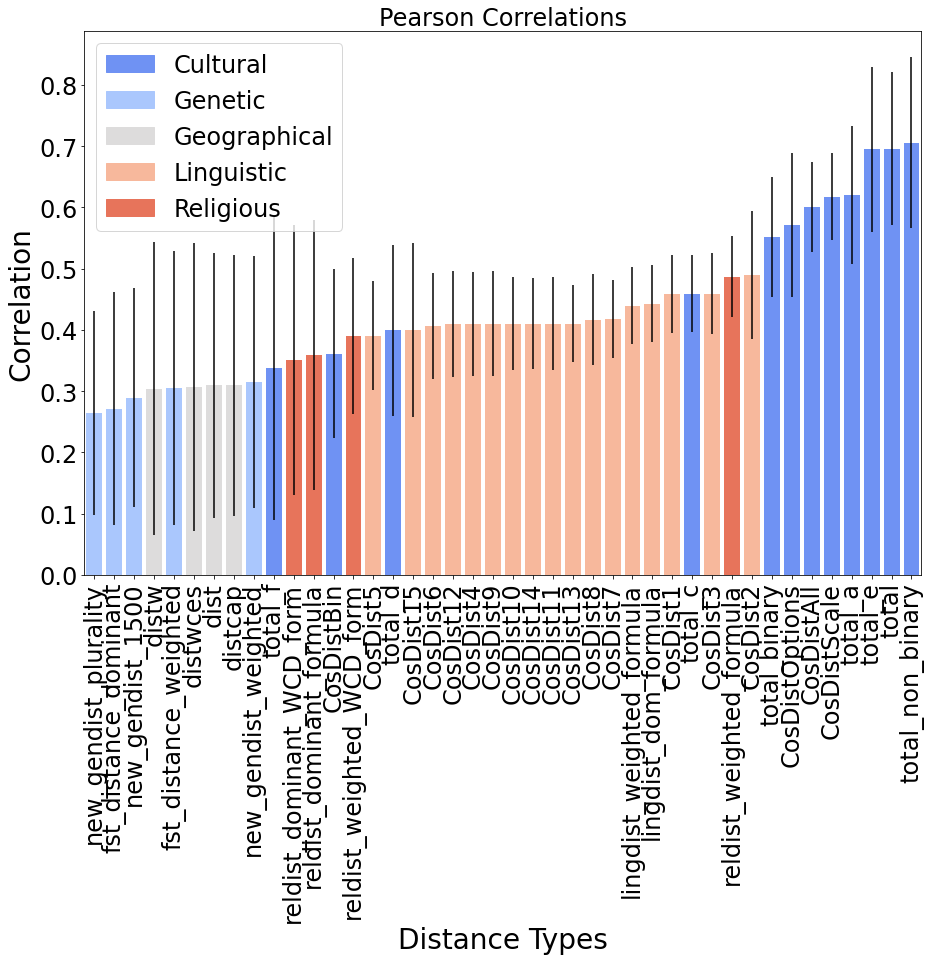

In [11]:
# Set seed for replication
def mymantel(Dist1, Dist2, ci=[5, 95], method='pearson', common=False, seed=128):
    '''Compute Mantel test between Distance 1 and 2'''
    np.random.seed(seed)
    if common==False:
        mydist = df[codes + [Dist1, Dist2]].copy()
    else:
        mydist = df.dropna(subset=measures)[codes + [Dist1, Dist2]].copy()
    mydist = mydist.dropna().reset_index(drop=True)
    otherdist = pd.pivot_table(mydist[codes + [Dist2]], index=codes[0], values=Dist2, columns=codes[1])
    mydist = pd.pivot_table(mydist[codes + [Dist1]], index=codes[0], values=Dist1, columns=codes[1])
    mydist = mydist.values
    np.fill_diagonal(mydist, 0)
    mydist = (mydist + mydist.T)/2
    otherdist = otherdist.values
    np.fill_diagonal(otherdist, 0)
    otherdist = (otherdist + otherdist.T)/2
    mymantel = MantelTest(mydist, otherdist, ci=ci, method=method)
    return mymantel

#######################################
# Figure with all measures
#######################################
codes = ['ISO_CODE_1', 'ISO_CODE_2']
corrs3m = corrs3.copy()
corrs3m = corrs3m.loc[corrs3m.Dist1=='FBDist']
corrs3m.reset_index(inplace=True, drop=True)
corrs3m['mymantel'] = corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2), axis=1)
corrs3m['mycorr'] = corrs3m.mymantel.apply(lambda x: x[0])
corrs3m['mylci'] = corrs3m.mymantel.apply(lambda x: x[3][0])
corrs3m['mycci'] = corrs3m.mymantel.apply(lambda x: x[3][1])
corrs3m['myerr'] = corrs3m['mycci'] - corrs3m['mycorr']
#corrs3m[corrs3m.columns.difference(['mymantel'])].to_stata(pathshare + 'FBCorrs.dta', write_index=False)
#corrs3m.to_csv(pathshare + 'FBCorrs.csv', index=False, encoding='utf8')

spear_corrs3m = spear_corrs3.copy()
spear_corrs3m = spear_corrs3m.loc[spear_corrs3m.Dist1=='FBDist']
spear_corrs3m.reset_index(inplace=True, drop=True)
spear_corrs3m['mymantel'] = spear_corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2, method='spearman'), axis=1)
spear_corrs3m['mycorr'] = spear_corrs3m.mymantel.apply(lambda x: x[0])
spear_corrs3m['mylci'] = spear_corrs3m.mymantel.apply(lambda x: x[3][0])
spear_corrs3m['mycci'] = spear_corrs3m.mymantel.apply(lambda x: x[3][1])
spear_corrs3m['myerr'] = spear_corrs3m['mycci'] - spear_corrs3m['mycorr']
#spear_corrs3m[spear_corrs3m.columns.difference(['mymantel'])].to_stata(pathshare + 'FBSpCorrs.dta', write_index=False)
#spear_corrs3m.to_csv(pathshare + 'FBSpCorrsAll.csv', index=False, encoding='utf8')

fig, ax = plt.subplots(figsize=(15,10))
palette = dict(zip(corrs3m.DistType.unique(), sns.color_palette("coolwarm", 5)))
palette2 = corrs3m[['Dist2', 'DistType']].set_index('Dist2')['DistType'].map(palette).to_dict()
sns.barplot(x="Dist2", y="mycorr",  data=corrs3m.loc[corrs3m.DistType_1=='FB'], order=corrs3m.sort_values('mycorr').Dist2, hue_order=corrs3m.sort_values('mycorr').DistType, palette=palette2,  ci=None, saturation=1, ax=ax, yerr=corrs3m.loc[corrs3m.DistType_1=='FB', 'myerr'])
ax.set_title('Pearson Correlations')
ax.set_ylabel('Correlation')
ax.set_xlabel('Distance Types')
ax.legend(loc='upper left')
handles = [mpatches.Patch(color=palette.get(c), label=c) for c in corrs3m.DistType.unique()]
ax.legend(handles=handles, labels=corrs3m.DistType.unique().tolist())
plt.xticks(rotation=90)
plt.savefig(pathshare+'TypeCorrsFBAll.pdf', dpi=300, bbox_inches='tight')
plt.show()

No handles with labels found to put in legend.


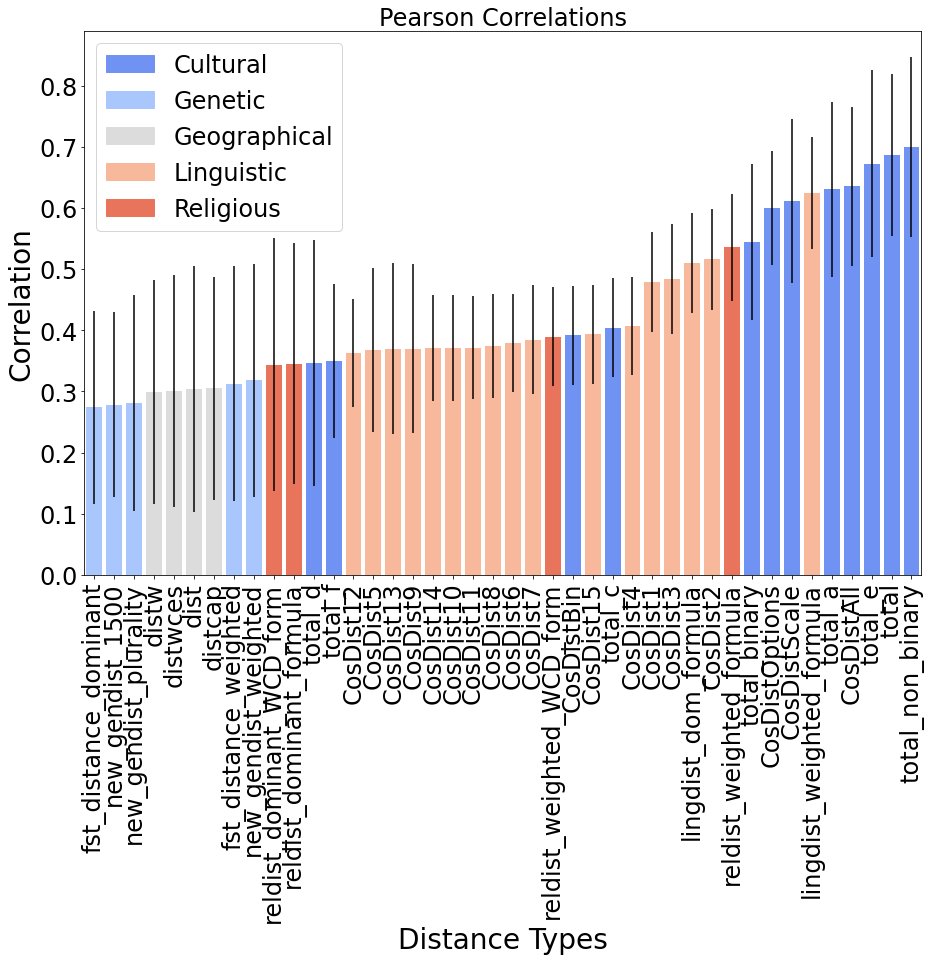

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
palette = dict(zip(spear_corrs3m.DistType.unique(), sns.color_palette("coolwarm", 5)))
palette2 = spear_corrs3m[['Dist2', 'DistType']].set_index('Dist2')['DistType'].map(palette).to_dict()
sns.barplot(x="Dist2", y="mycorr",  data=spear_corrs3m.loc[spear_corrs3m.DistType_1=='FB'], order=spear_corrs3m.sort_values('mycorr').Dist2, hue_order=spear_corrs3m.sort_values('mycorr').DistType, palette=palette2,  ci=None, saturation=1, ax=ax, yerr=spear_corrs3m.loc[corrs3m.DistType_1=='FB', 'myerr'])
ax.set_title('Pearson Correlations')
ax.set_ylabel('Correlation')
ax.set_xlabel('Distance Types')
ax.legend(loc='upper left')
handles = [mpatches.Patch(color=palette.get(c), label=c) for c in spear_corrs3m.DistType.unique()]
ax.legend(handles=handles, labels=spear_corrs3m.DistType.unique().tolist())
plt.xticks(rotation=90)
plt.savefig(pathshare+'TypeSpCorrsFBAll.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Common Sample

No handles with labels found to put in legend.


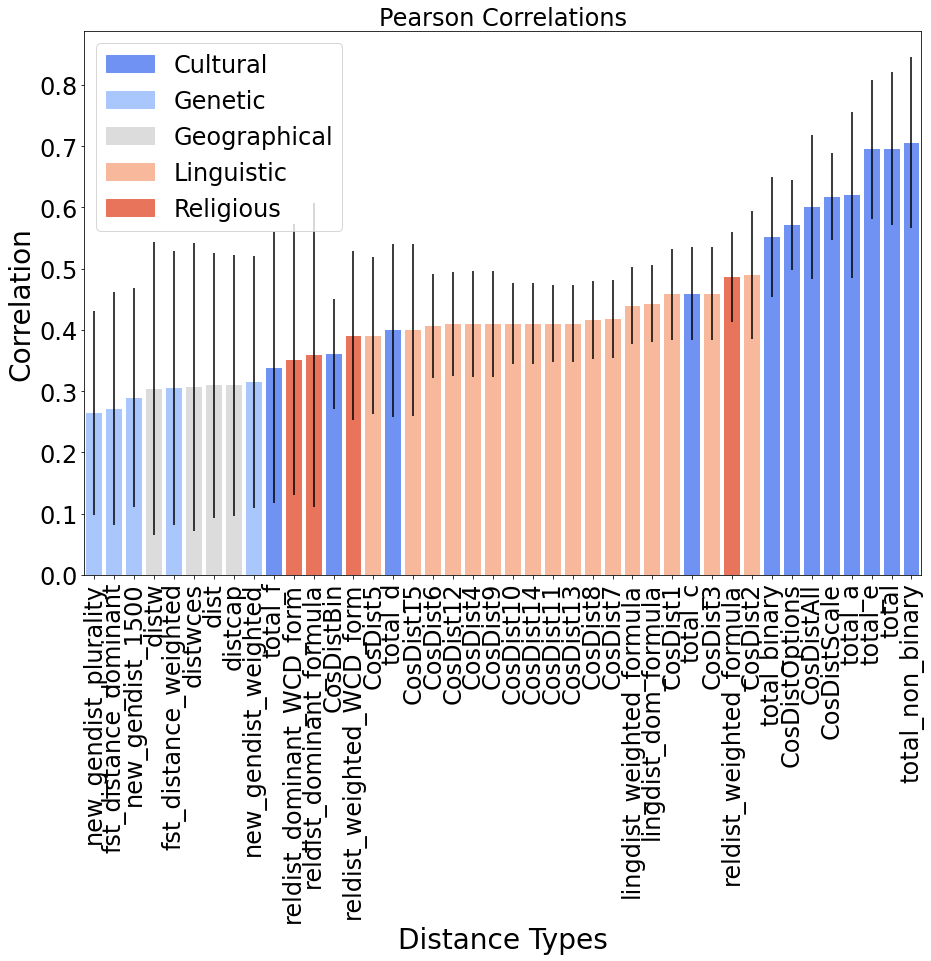

In [13]:
codes = ['ISO_CODE_1', 'ISO_CODE_2']
corrs3m = corrs_com3.copy()
corrs3m = corrs3m.loc[corrs3m.Dist1=='FBDist']
corrs3m.reset_index(inplace=True, drop=True)
corrs3m['mymantel'] = corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2), axis=1)
corrs3m['mycorr'] = corrs3m.mymantel.apply(lambda x: x[0])
corrs3m['mypval'] = corrs3m.mymantel.apply(lambda x: x[1])
corrs3m['mylci'] = corrs3m.mymantel.apply(lambda x: x[3][0])
corrs3m['mycci'] = corrs3m.mymantel.apply(lambda x: x[3][1])
corrs3m['myerr'] = corrs3m['mycci'] - corrs3m['mycorr']
corrs3m[corrs3m.columns.difference(['mymantel'])].to_stata(pathshare + 'FBCorrs_com.dta', write_index=False)
#corrs3m.to_csv(pathshare + 'FBCorrs_com.csv', index=False, encoding='utf8')

spear_corrs3m = spear_corrs_com3.copy()
spear_corrs3m = spear_corrs3m.loc[spear_corrs3m.Dist1=='FBDist']
spear_corrs3m.reset_index(inplace=True, drop=True)
spear_corrs3m['mymantel'] = spear_corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2, method='spearman'), axis=1)
spear_corrs3m['mycorr'] = spear_corrs3m.mymantel.apply(lambda x: x[0])
spear_corrs3m['mypval'] = spear_corrs3m.mymantel.apply(lambda x: x[1])
spear_corrs3m['mylci'] = spear_corrs3m.mymantel.apply(lambda x: x[3][0])
spear_corrs3m['mycci'] = spear_corrs3m.mymantel.apply(lambda x: x[3][1])
spear_corrs3m['myerr'] = spear_corrs3m['mycci'] - spear_corrs3m['mycorr']
#spear_corrs3m[spear_corrs3m.columns.difference(['mymantel'])].to_stata(pathshare + 'FBSpCorrs_com.dta', write_index=False)
#spear_corrs3m.to_csv(pathshare + 'FBSpCorrs_com.csv', index=False, encoding='utf8')

fig, ax = plt.subplots(figsize=(15,10))
palette = dict(zip(corrs3m.DistType.unique(), sns.color_palette("coolwarm", 5)))
palette2 = corrs3m[['Dist2', 'DistType']].set_index('Dist2')['DistType'].map(palette).to_dict()
sns.barplot(x="Dist2", y="mycorr",  data=corrs3m.loc[corrs3m.DistType_1=='FB'], order=corrs3m.sort_values('mycorr').Dist2, hue_order=corrs3m.sort_values('mycorr').DistType, palette=palette2,  ci=None, saturation=1, ax=ax, yerr=corrs3m.loc[corrs3m.DistType_1=='FB', 'myerr'])
ax.set_title('Pearson Correlations')
ax.set_ylabel('Correlation')
ax.set_xlabel('Distance Types')
ax.legend(loc='upper left')
handles = [mpatches.Patch(color=palette.get(c), label=c) for c in corrs3m.DistType.unique()]
ax.legend(handles=handles, labels=corrs3m.DistType.unique().tolist(), loc='upper left')
plt.xticks(rotation=90)
plt.savefig(pathshare+'TypeCorrsFB_comAll.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Top 4 Correlations by Type

In [14]:
# Common Sample
corrs3m_copy = corrs3m.copy()
corrs3m = corrs3m.merge(corrs3m.groupby('DistType').mycorr.max().reset_index(), how='left', on='DistType', suffixes=['', '_gr'])
corrs3m.sort_values(['mycorr_gr', 'mycorr'], ascending=False, inplace=True)
corrs3m = corrs3m.groupby('DistType').head(4).reset_index(drop=True)
corrs3m['Dist2'] = corrs3m['DistType'] + ' ' + (corrs3m.groupby('DistType').cumcount()+1).astype(str)
corrs3m['Dist2'] = corrs3m['Dist2'].apply(lambda x: x.replace('Geographical', 'Geog.'))

No handles with labels found to put in legend.


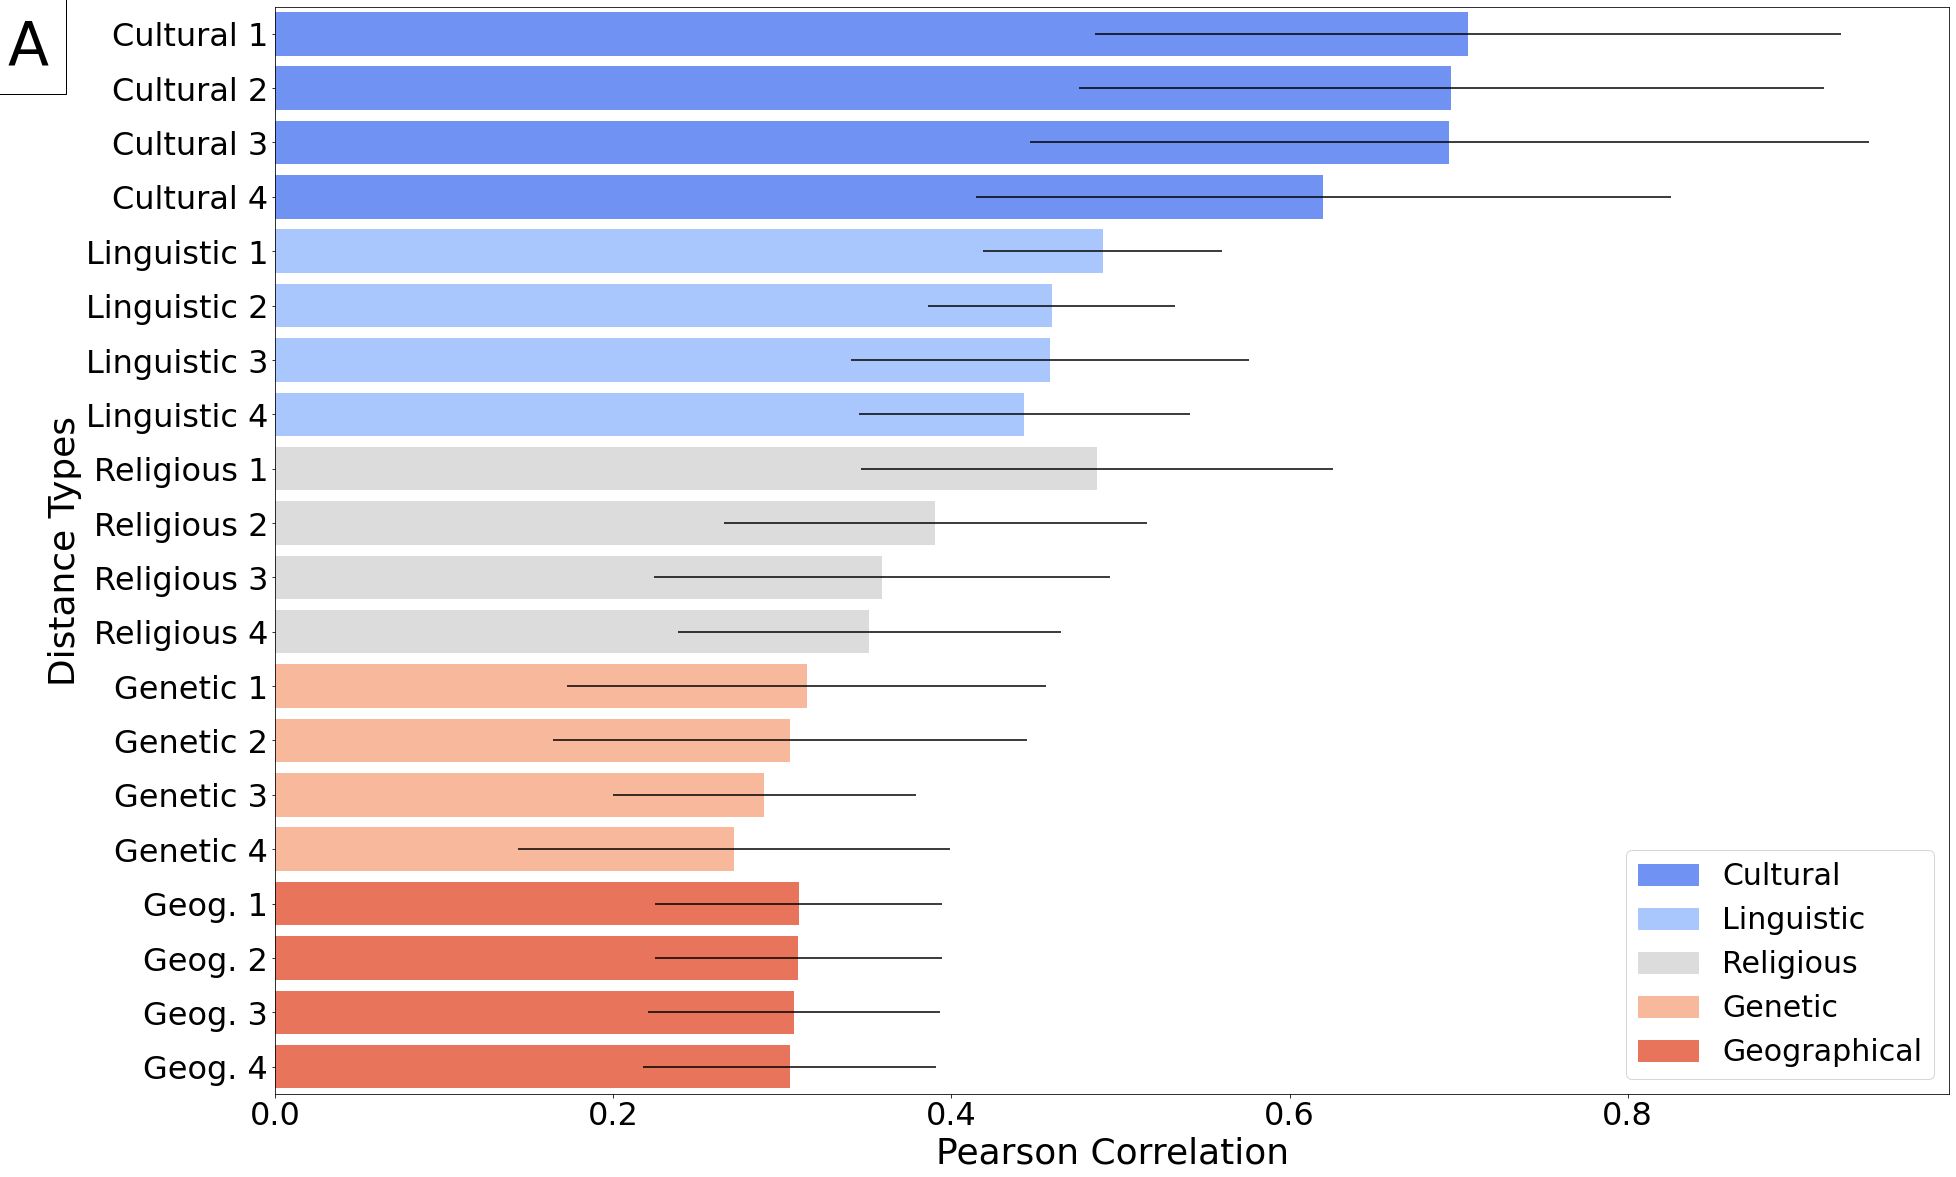

In [15]:
textstr = 'A'
props = dict(boxstyle='square', facecolor='white', alpha=1)
fig, ax = plt.subplots(figsize=(30,20))
palette = dict(zip(corrs3m.DistType.unique(), sns.color_palette("coolwarm", 5)))
palette2 = corrs3m[['Dist2', 'DistType']].set_index('Dist2')['DistType'].map(palette).to_dict()
sns.barplot(y="Dist2", x="mycorr",  data=corrs3m.loc[corrs3m.DistType_1=='FB'], order=corrs3m.sort_values(['mycorr_gr', 'mycorr'], ascending=False).Dist2, hue_order=corrs3m.sort_values('mycorr', ascending=False).DistType, palette=palette2,  ci=None, saturation=1, ax=ax, xerr=corrs3m.loc[corrs3m.DistType_1=='FB', 'myerr'])
ax.tick_params(axis = 'both', which = 'major', labelsize=32)
ax.tick_params(axis = 'both', which = 'minor', labelsize=16)
ax.set_title('')
ax.set_xlabel('Pearson Correlation', fontsize=36)
ax.set_ylabel('Distance Types', fontsize=36)
ax.legend(loc='upper left')
handles = [mpatches.Patch(color=palette.get(c), label=c) for c in corrs3m.DistType.unique()]
ax.legend(handles=handles, labels=corrs3m.DistType.unique().tolist(), prop={'size': 30}, loc='lower right')
ax.text(-0.16, 0.99, textstr, transform=ax.transAxes, fontsize=60, verticalalignment='top', bbox=props)
plt.savefig(pathshare+'Figure-2-A.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Correlations of Selected Measures (Full Sample -  Figure B5)

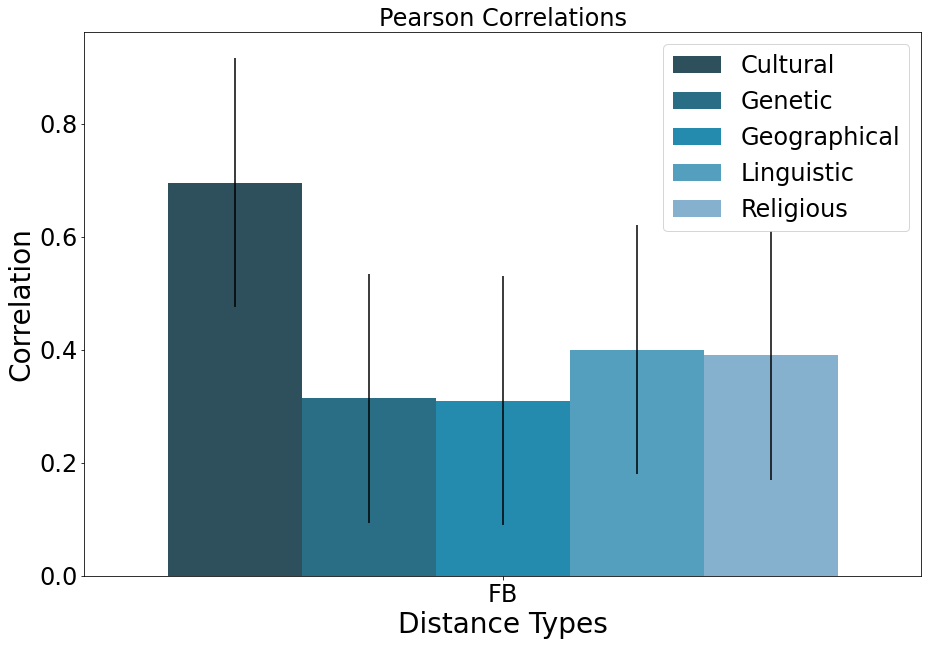

In [16]:
codes = ['ISO_CODE_1', 'ISO_CODE_2']
corrs3m = corrs3.copy()
corrs3m = corrs3m.loc[corrs3m.Dist1.apply(lambda x: x in measures)]
corrs3m = corrs3m.loc[corrs3m.Dist2.apply(lambda x: x in measures)]
corrs3m.reset_index(inplace=True, drop=True)
corrs3m['mymantel'] = corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2), axis=1)
corrs3m['mycorr'] = corrs3m.mymantel.apply(lambda x: x[0])
corrs3m['mylci'] = corrs3m.mymantel.apply(lambda x: x[3][0])
corrs3m['mycci'] = corrs3m.mymantel.apply(lambda x: x[3][1])
corrs3m['myerr'] = corrs3m['mycci'] - corrs3m['mycorr']
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DistType_1", y="mycorr", hue="DistType", data=corrs3m.loc[corrs3m.DistType_1=='FB'], palette='PuBuGn_r_d', estimator=np.max, ci=None, saturation=1, ax=ax, yerr=[corrs3m.loc[corrs3m.DistType_1=='FB', 'myerr'].values[0]])
ax.set_title('Pearson Correlations')
ax.set_ylabel('Correlation')
ax.set_xlabel('Distance Types')
ax.legend(loc='upper right')
plt.savefig(pathout+'Figure-B5-A.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Correlations of Selected Measures (Common Sample)

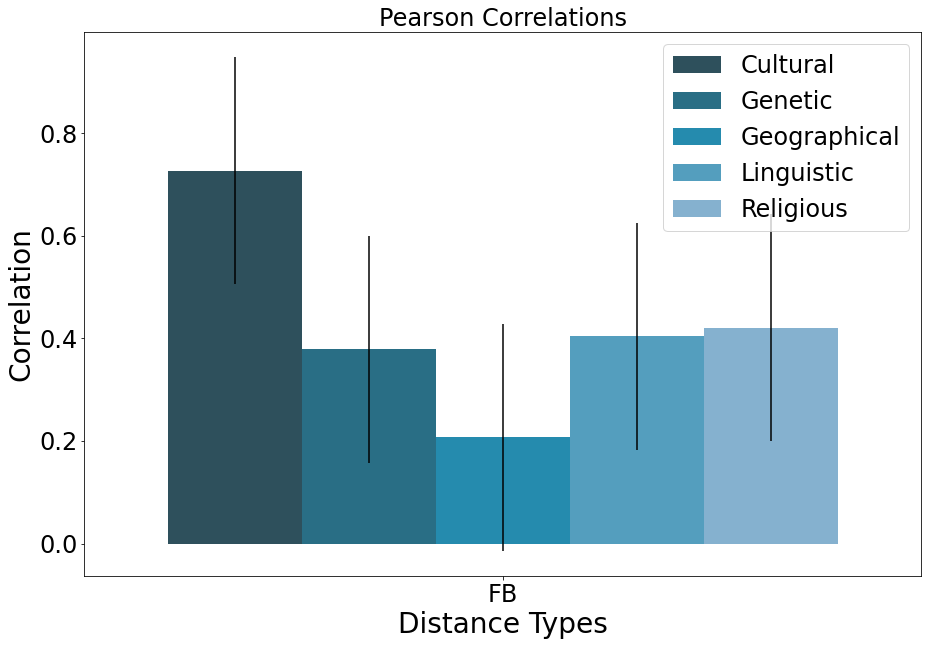

In [17]:
# List of measures by Type Common sample
corrs3m = corrs_com3.copy()
corrs3m = corrs3m.loc[corrs3m.Dist1.apply(lambda x: x in measures)]
corrs3m = corrs3m.loc[corrs3m.Dist2.apply(lambda x: x in measures)]
corrs3m.reset_index(inplace=True, drop=True)
corrs3m['mymantel'] = corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2, common=True), axis=1)
corrs3m['mycorr'] = corrs3m.mymantel.apply(lambda x: x[0])
corrs3m['mylci'] = corrs3m.mymantel.apply(lambda x: x[3][0])
corrs3m['mycci'] = corrs3m.mymantel.apply(lambda x: x[3][1])
corrs3m['myerr'] = corrs3m['mycci'] - corrs3m['mycorr']

spear_corrs3m = spear_corrs_com3.copy()
spear_corrs3m = spear_corrs3m.loc[spear_corrs3m.Dist1.apply(lambda x: x in measures)]
spear_corrs3m = spear_corrs3m.loc[spear_corrs3m.Dist2.apply(lambda x: x in measures)]
spear_corrs3m.reset_index(inplace=True, drop=True)
spear_corrs3m['mymantel'] = spear_corrs3m.apply(lambda x: mymantel(x.Dist1, x.Dist2, common=True, method='spearman'), axis=1)
spear_corrs3m['mycorr'] = spear_corrs3m.mymantel.apply(lambda x: x[0])
spear_corrs3m['mylci'] = spear_corrs3m.mymantel.apply(lambda x: x[3][0])
spear_corrs3m['mycci'] = spear_corrs3m.mymantel.apply(lambda x: x[3][1])
spear_corrs3m['myerr'] = spear_corrs3m['mycci'] - spear_corrs3m['mycorr']

# List by Type FB Only Common Sample
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DistType_1", y="mycorr", hue="DistType", data=corrs3m.loc[corrs3m.DistType_1=='FB'], palette='PuBuGn_r_d', estimator=np.max, ci=None, saturation=1, ax=ax, yerr=[corrs3m.loc[corrs3m.DistType_1=='FB', 'myerr'].values[0]])
ax.set_title('Pearson Correlations')
ax.set_ylabel('Correlation')
ax.set_xlabel('Distance Types')
ax.legend(loc='upper right')
plt.savefig(pathout+'Figure-B5-B.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Regression Analysis and Partial Mantel Tests

## Figure-B5-C
## Partial Correlation (Residuals on Residuals)

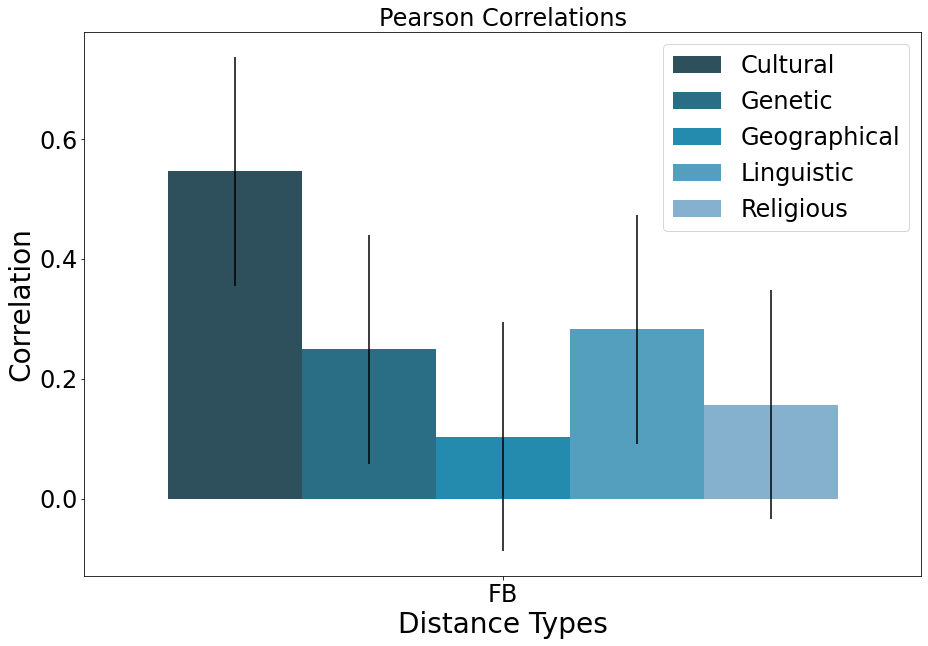

In [18]:
# Some functions required for the analyses
# Regressions
def mysample(myvars, df, FE=True, dummy_cols=['ISO_CODE_1', 'ISO_CODE_2'],
             cluster_cols = ['ISO_CODE_1', 'ISO_CODE_2'], zscores=True):
    '''
    Create sample dataframe based on variables
    First variable is dependent variable
    It adds dummies for FE
    Adds cluster variables
    '''
    if len(myvars)<2:
        print('A regression needs at least one dependent and one independent variable!')
        pass
    else:
        k = 0
        for v in myvars:
            if k==0:
                mydf = (df[v].isnull()==False).astype(int)
                k += 1
            else:
                mydf *= (df[v].isnull()==False).astype(int)
        mydf = df.loc[mydf==1].reset_index(drop=True).copy()
        if zscores:
            mydf[myvars] = mydf[myvars].apply(zscore)
        myeq = myvars[0] + ' ~ ' + " + ".join(myvars[1:])
        if FE:
            dummies = pd.get_dummies(mydf[dummy_cols], prefix='_I', prefix_sep='_')
            dummies = dummies.T.groupby(level=0).sum().T
            dummy_columns = " + ".join(dummies.columns)
            myeq += ' + ' + dummy_columns
            mydf = mydf.merge(dummies, left_index=True, right_index=True).copy()
        clustercols = []
        for v in cluster_cols:
            mydf['cluster_'+v] = mydf[v].astype('category').cat.codes
            clustercols.append('cluster_'+v)
        return [mydf, myeq, clustercols]

# Partial Mantel Test
def mymantelreg(Dist1, Dist2,  ci=[5, 95], method='pearson', seed=128, FE=True, **kwds):
    '''Compute Mantel test between Distance 1 and 2'''
    np.random.seed(seed)
    othervars = pd.Index(measures).difference([Dist1, Dist2]).tolist()
    mydist = df[codes + measures].copy()
    mydist = mydist.dropna().reset_index(drop=True)
    myvars = [Dist1, Dist2]
    for y in myvars:
        [mydf, myeq, clustercols] = mysample([y] + othervars, mydist, FE=FE)
        results1 = smf.ols(myeq, data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})
        #print(results1.summary())
        mydist[y + '_res'] = results1.resid
    results1 = smf.ols(Dist1+'_res' + ' ~ ' + Dist2 + '_res ' , data=mydist).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})
    #print(results1.summary())
    results1 = smf.ols(Dist1 + ' ~ ' + Dist2 + '_res ' , data=mydist).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})
    #print(results1.summary())
    r1 = results1.rsquared
    otherdist = pd.pivot_table(mydist[codes + [Dist2 + '_res']], index=codes[0], values=Dist2 + '_res', columns=codes[1])
    mydistor = pd.pivot_table(mydist[codes + [Dist1 ]], index=codes[0], values=Dist1 , columns=codes[1])
    mydist = pd.pivot_table(mydist[codes + [Dist1 + '_res']], index=codes[0], values=Dist1 + '_res', columns=codes[1])
    mydist = mydist.values
    np.fill_diagonal(mydist, 0)
    mydist = (mydist + mydist.T)/2
    mydistor = mydistor.values
    np.fill_diagonal(mydistor, 0)
    mydistor = (mydistor + mydistor.T)/2
    otherdist = otherdist.values
    np.fill_diagonal(otherdist, 0)
    otherdist = (otherdist + otherdist.T)/2
    mymantel = MantelTest(mydist, otherdist, ci=ci, method=method)
    mymantel_semi = MantelTest(mydistor, otherdist, ci=ci, method=method)
    return mymantel, r1, mymantel_semi

# NO FE
codes = ['ISO_CODE_1', 'ISO_CODE_2']
corrs3m = corrs3.copy()
corrs3m = corrs3m.loc[corrs3m.Dist1.apply(lambda x: x in measures)]
corrs3m = corrs3m.loc[corrs3m.Dist2.apply(lambda x: x in measures)]
corrs3m.reset_index(inplace=True, drop=True)
corrs3m['mymantel'] = corrs3m.apply(lambda x: mymantelreg(x.Dist1, x.Dist2, FE=False), axis=1)
corrs3m['mycorr'] = corrs3m.mymantel.apply(lambda x: x[0][0])
corrs3m['mylci'] = corrs3m.mymantel.apply(lambda x: x[0][3][0])
corrs3m['mycci'] = corrs3m.mymantel.apply(lambda x: x[0][3][1])
corrs3m['myerr'] = corrs3m['mycci'] - corrs3m['mycorr']
corrs3m['semi-partial'] = corrs3m.mymantel.apply(lambda x: x[1])
corrs3m['mycorr_semi'] = corrs3m.mymantel.apply(lambda x: x[2][0])
corrs3m['mylci_semi'] = corrs3m.mymantel.apply(lambda x: x[2][3][0])
corrs3m['mycci_semi'] = corrs3m.mymantel.apply(lambda x: x[2][3][1])
corrs3m['myerr_semi'] = corrs3m['mycci_semi'] - corrs3m['mycorr_semi']

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DistType_1", y="mycorr", hue="DistType", data=corrs3m.loc[corrs3m.DistType_1=='FB'], palette='PuBuGn_r_d', estimator=np.max, ci=None, saturation=1, ax=ax, yerr=[corrs3m.loc[corrs3m.DistType_1=='FB', 'myerr'].values[0]])
ax.set_title('Pearson Correlations')
ax.set_ylabel('Correlation')
ax.set_xlabel('Distance Types')
ax.legend(loc='upper right')
plt.savefig(pathout+'Figure-B5-C.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Semi-Partial $R^2$

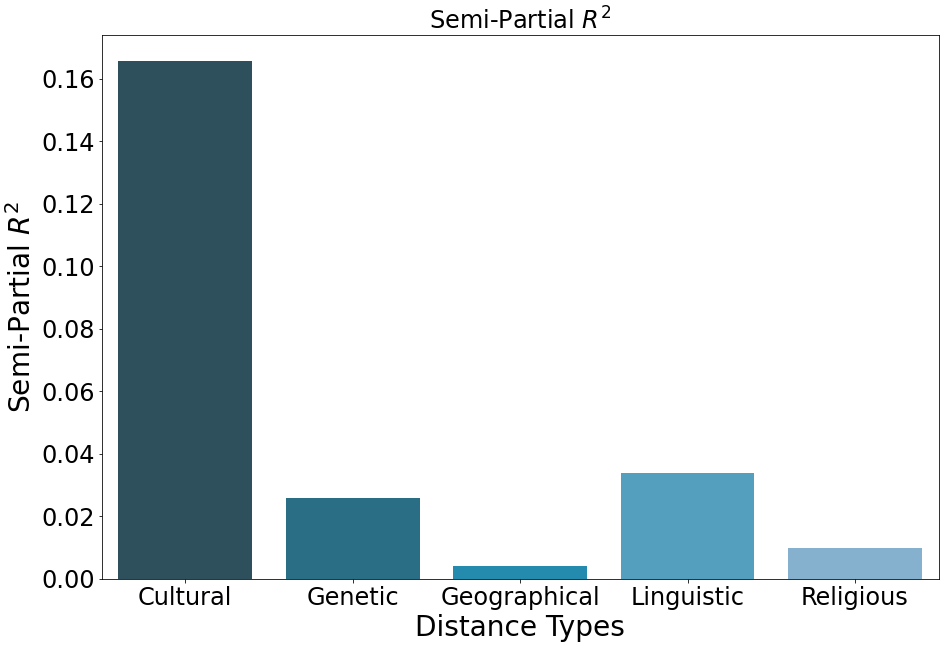

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DistType", y="semi-partial", data=corrs3m.loc[corrs3m.DistType_1=='FB'], palette='PuBuGn_r_d', estimator=np.mean, ci=None, saturation=1, ax=ax)
ax.set_title(r"Semi-Partial $R^2$")
ax.set_ylabel(r'Semi-Partial $R^2$')
ax.set_xlabel('Distance Types')
#ax.legend(loc='upper left')
plt.savefig(pathout+'Figure-B5-E.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Semi-Partial Correlation

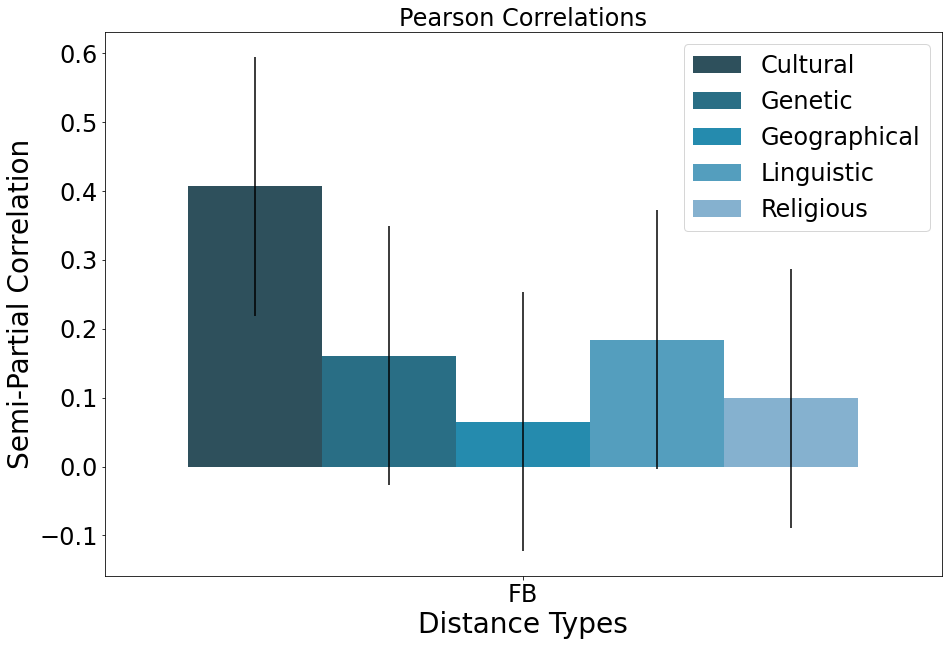

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DistType_1", y="mycorr_semi", hue="DistType", data=corrs3m.loc[corrs3m.DistType_1=='FB'], palette='PuBuGn_r_d', estimator=np.max, ci=None, saturation=1, ax=ax, yerr=[corrs3m.loc[corrs3m.DistType_1=='FB', 'myerr_semi'].values[0]])
ax.set_title('Pearson Correlations')
ax.set_ylabel('Semi-Partial Correlation')
ax.set_xlabel('Distance Types')
ax.legend(loc='upper right')
plt.savefig(pathout+'Figure-B5-D.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Robustness -  By Type of Distance (Figure B2 - robustness)

### Semi-Partial $R^2$ (Joint)

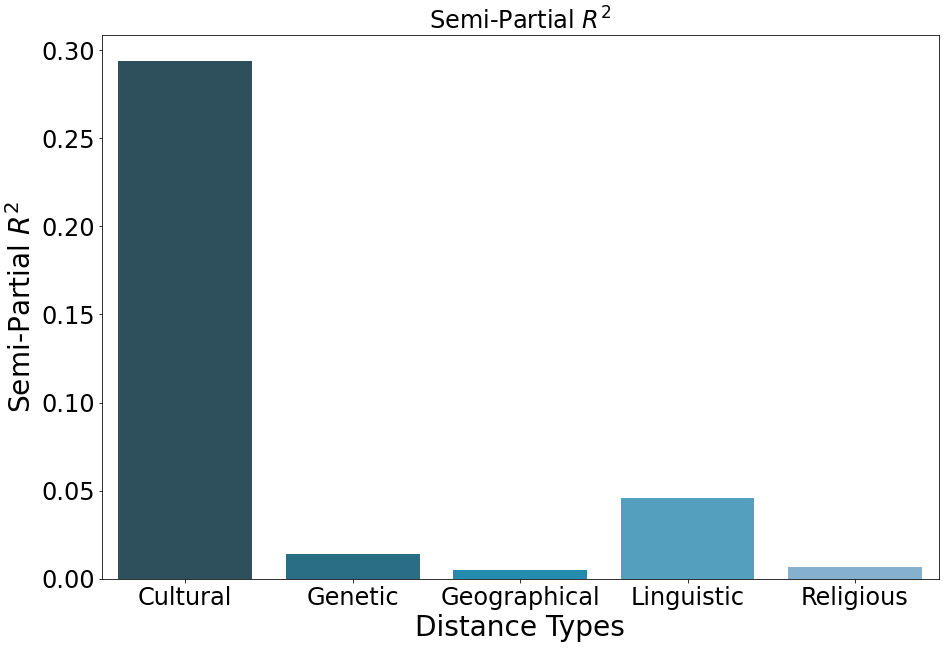

In [21]:
# Semi-Partial R^2
FBcorrRegs = FBcorr.copy()
FBcorrRegs = FBcorrRegs.loc[FBcorrRegs.Dist2.apply(lambda x: x.find('cognate')==-1)]
FBcorrRegs['DistType'] = FBcorrRegs.Dist2.apply(assign_type)
FBcorrRegs = FBcorrRegs.sort_values(['DistType', 'Dist2']).reset_index(drop=True)
allcols = FBcorrRegs.Dist2.tolist()
for m in set(FBcorrRegs.DistType):
    mcols = FBcorrRegs.loc[FBcorrRegs.DistType==m]['Dist2'].tolist()
    diffcols = list(set(allcols).difference(set(mcols)))
    myvars = ['FBDist'] + allcols
    [mydf, myeq, clustercols] = mysample(myvars, mypairs, FE=False)
    results1 = smf.ols(myeq, data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})
    r1 = results1.rsquared
    myvars = ['FBDist'] + diffcols
    [mydf, myeq, clustercols] = mysample(myvars, mypairs, FE=False)
    results1 = smf.ols(myeq, data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})
    FBcorrRegs.loc[FBcorrRegs.DistType==m, 'Semi-Partial-R2'] = r1 - results1.rsquared

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DistType", y="Semi-Partial-R2", data=FBcorrRegs, palette='PuBuGn_r_d', estimator=np.mean, ci=99, saturation=1, ax=ax)
ax.set_title(r"Semi-Partial $R^2$")
ax.set_ylabel(r'Semi-Partial $R^2$')
ax.set_xlabel('Distance Types')
#ax.legend(loc='upper left')
plt.savefig(pathout+'TypeRegsSemiPartialR2.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Semi-Partial $R^2$ (Individual)

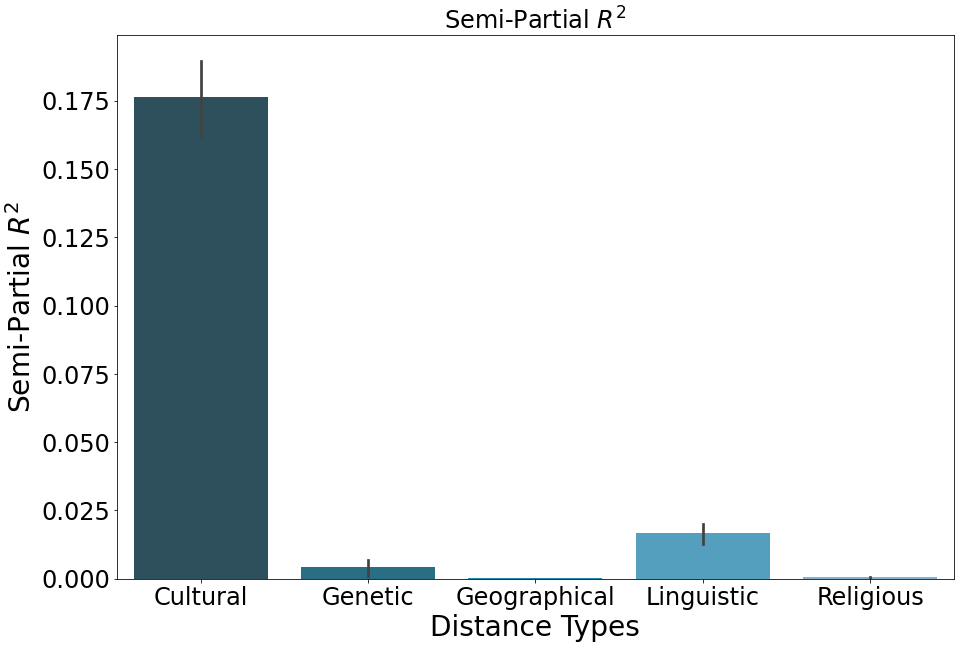

In [22]:
# Semi-Partial R^2 by measure controlling for all measures of all other types
FBcorrRegs = FBcorr.copy()
FBcorrRegs['DistType'] = FBcorrRegs.Dist2.apply(assign_type)
FBcorrRegs = FBcorrRegs.sort_values(['DistType', 'Dist2']).reset_index(drop=True)
allcols = FBcorrRegs.Dist2.tolist()
for m in set(FBcorrRegs.DistType):
    mcols = FBcorrRegs.loc[FBcorrRegs.DistType==m]['Dist2'].tolist()
    diffcols = list(set(allcols).difference(set(mcols)))
    for m1 in mcols:
        myvars = ['FBDist'] + diffcols + [m1]
        [mydf, myeq, clustercols] = mysample(myvars, mypairs, FE=False)
        results1 = smf.ols(myeq, data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})
        r1 = results1.rsquared
        myvars = ['FBDist'] + diffcols
        [mydf, myeq, clustercols] = mysample(myvars, mypairs, FE=False)
        results1 = smf.ols(myeq, data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})
        FBcorrRegs.loc[FBcorrRegs.Dist2==m1, 'Semi-Partial-R2'] = r1 - results1.rsquared

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DistType", y="Semi-Partial-R2", data=FBcorrRegs, palette='PuBuGn_r_d', estimator=np.mean, ci=99, saturation=1, ax=ax)
ax.set_title(r"Semi-Partial $R^2$")
ax.set_ylabel(r'Semi-Partial $R^2$')
ax.set_xlabel('Distance Types')
#ax.legend(loc='upper left')
plt.savefig(pathout+'TypeRegsSemiPartialR2Plus.pdf', dpi=300, bbox_inches='tight')
plt.show()